<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session7/EVA7_Assignment7_AdvancedConcepts_AbhinavP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA7 - Assignment 7 - Advanced Concepts

Submission by Abhinav Pujahari (abhinavpujahari@gmail.com) - Group 9

## Goals
1. Create a classification NN to train the CIFAR10 dataset to beyond 87% accuracy.
2. Network must have less than 100k parameters
3. One of the layers must use dilated convolution
4. 2 of the layers must use depthwise separable convolution
5. GAP must be used and mapped to the number of classes
6. Use Albumentation library to apply transformations
7. Code must be modular

## Import Dependencies

In [1]:
!pip install albumentations==0.4.6
!pip install torchsummary

In [2]:
import torch
import torchvision
import data_handling as d
import model_updated as m
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, OneCycleLR, LambdaLR, CosineAnnealingLR
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## GPU Check

In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


CUDA Available? True


## Data Download, Transformations & Dataset Creation

In [4]:
## Get Dataset Statistics
mean, std = d.return_dataset_statistics()

## Define data transformations
train_transforms, test_transforms = d.albumentation_augmentation(mean, std)

## Download & return transformed datasets
trainset, testset = d.return_datasets(train_transforms, test_transforms)

## Define data loaders
trainloader, testloader = d.return_dataloaders(trainset, testset, cuda)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Visualize Data Examples

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship  bird   cat   dog  bird truck truck plane plane  ship truck  frog  bird  bird   dog  frog


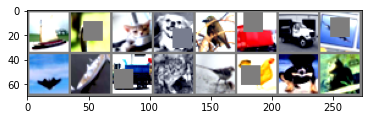

In [5]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:16]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

## Model Summary

In [6]:
from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)
model = m.Net(0.01).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 30, 30]             324
              ReLU-2           [-1, 12, 30, 30]               0
       BatchNorm2d-3           [-1, 12, 30, 30]              24
           Dropout-4           [-1, 12, 30, 30]               0
            Conv2d-5           [-1, 24, 28, 28]           2,592
              ReLU-6           [-1, 24, 28, 28]               0
       BatchNorm2d-7           [-1, 24, 28, 28]              48
           Dropout-8           [-1, 24, 28, 28]               0
            Conv2d-9           [-1, 48, 14, 14]          10,368
             ReLU-10           [-1, 48, 14, 14]               0
      BatchNorm2d-11           [-1, 48, 14, 14]              96
          Dropout-12           [-1, 48, 14, 14]               0
           Conv2d-13           [-1, 48, 14, 14]          20,736
             ReLU-14           [-1

## Model Training

In [7]:
import train, test
train_acc, train_losses, test_acc, test_losses, lrs = [], [], [], [], []

## Define Optimizer
optimizer = optim.Adam(model.parameters(), lr = 0.01, weight_decay=1e-5)

## Define Scheduler
scheduler = OneCycleLR(optimizer, max_lr = 0.015, epochs = 100, steps_per_epoch = len(trainloader))

## Define loss function
criterion = nn.CrossEntropyLoss()

## Define number of epochs and begin training
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train.train(model, device, trainloader, train_acc, train_losses, optimizer, scheduler, criterion, lrs)
    test.test(model, device, testloader, test_acc, test_losses, criterion)


EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.3672443628311157 Batch_id=390 LR=0.00064 Accuracy=41.65: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s]



Test set: Average loss: 0.0102, Accuracy: 5762/10000 (57.62%)

EPOCH: 2


Loss=1.3712303638458252 Batch_id=390 LR=0.00076 Accuracy=53.43: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s]



Test set: Average loss: 0.0089, Accuracy: 6275/10000 (62.75%)

EPOCH: 3


Loss=1.2004119157791138 Batch_id=390 LR=0.00095 Accuracy=57.95: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]



Test set: Average loss: 0.0077, Accuracy: 6704/10000 (67.04%)

EPOCH: 4


Loss=1.1893805265426636 Batch_id=390 LR=0.00122 Accuracy=61.16: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s]



Test set: Average loss: 0.0072, Accuracy: 6855/10000 (68.55%)

EPOCH: 5


Loss=1.123180627822876 Batch_id=390 LR=0.00156 Accuracy=63.19: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s]



Test set: Average loss: 0.0068, Accuracy: 7101/10000 (71.01%)

EPOCH: 6


Loss=1.0239121913909912 Batch_id=390 LR=0.00198 Accuracy=64.96: 100%|██████████| 391/391 [00:19<00:00, 20.52it/s]



Test set: Average loss: 0.0064, Accuracy: 7228/10000 (72.28%)

EPOCH: 7


Loss=0.830051600933075 Batch_id=390 LR=0.00245 Accuracy=66.16: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]



Test set: Average loss: 0.0062, Accuracy: 7322/10000 (73.22%)

EPOCH: 8


Loss=0.8421778678894043 Batch_id=390 LR=0.00298 Accuracy=67.17: 100%|██████████| 391/391 [00:19<00:00, 20.47it/s]



Test set: Average loss: 0.0057, Accuracy: 7523/10000 (75.23%)

EPOCH: 9


Loss=0.8665561676025391 Batch_id=390 LR=0.00357 Accuracy=68.14: 100%|██████████| 391/391 [00:19<00:00, 20.02it/s]



Test set: Average loss: 0.0059, Accuracy: 7378/10000 (73.78%)

EPOCH: 10


Loss=1.009823203086853 Batch_id=390 LR=0.00420 Accuracy=68.80: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.0055, Accuracy: 7614/10000 (76.14%)

EPOCH: 11


Loss=0.8043869733810425 Batch_id=390 LR=0.00487 Accuracy=69.52: 100%|██████████| 391/391 [00:18<00:00, 20.75it/s]



Test set: Average loss: 0.0055, Accuracy: 7540/10000 (75.40%)

EPOCH: 12


Loss=0.7688965797424316 Batch_id=390 LR=0.00558 Accuracy=69.86: 100%|██████████| 391/391 [00:19<00:00, 20.52it/s]



Test set: Average loss: 0.0053, Accuracy: 7690/10000 (76.90%)

EPOCH: 13


Loss=0.7142507433891296 Batch_id=390 LR=0.00630 Accuracy=70.60: 100%|██████████| 391/391 [00:18<00:00, 20.58it/s]



Test set: Average loss: 0.0053, Accuracy: 7709/10000 (77.09%)

EPOCH: 14


Loss=0.9152935743331909 Batch_id=390 LR=0.00705 Accuracy=71.04: 100%|██████████| 391/391 [00:19<00:00, 20.32it/s]



Test set: Average loss: 0.0063, Accuracy: 7364/10000 (73.64%)

EPOCH: 15


Loss=0.824735164642334 Batch_id=390 LR=0.00780 Accuracy=71.56: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]



Test set: Average loss: 0.0053, Accuracy: 7789/10000 (77.89%)

EPOCH: 16


Loss=0.835771918296814 Batch_id=390 LR=0.00855 Accuracy=71.54: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s]



Test set: Average loss: 0.0052, Accuracy: 7801/10000 (78.01%)

EPOCH: 17


Loss=0.830295205116272 Batch_id=390 LR=0.00930 Accuracy=72.04: 100%|██████████| 391/391 [00:19<00:00, 20.24it/s]



Test set: Average loss: 0.0052, Accuracy: 7795/10000 (77.95%)

EPOCH: 18


Loss=0.8351756930351257 Batch_id=390 LR=0.01003 Accuracy=72.37: 100%|██████████| 391/391 [00:19<00:00, 20.52it/s]



Test set: Average loss: 0.0048, Accuracy: 7958/10000 (79.58%)

EPOCH: 19


Loss=0.8323174715042114 Batch_id=390 LR=0.01073 Accuracy=72.77: 100%|██████████| 391/391 [00:19<00:00, 20.34it/s]



Test set: Average loss: 0.0052, Accuracy: 7806/10000 (78.06%)

EPOCH: 20


Loss=0.9009988903999329 Batch_id=390 LR=0.01140 Accuracy=72.98: 100%|██████████| 391/391 [00:19<00:00, 20.32it/s]



Test set: Average loss: 0.0051, Accuracy: 7790/10000 (77.90%)

EPOCH: 21


Loss=0.5461057424545288 Batch_id=390 LR=0.01203 Accuracy=73.11: 100%|██████████| 391/391 [00:19<00:00, 20.56it/s]



Test set: Average loss: 0.0049, Accuracy: 7865/10000 (78.65%)

EPOCH: 22


Loss=0.5519801378250122 Batch_id=390 LR=0.01262 Accuracy=73.44: 100%|██████████| 391/391 [00:18<00:00, 21.24it/s]



Test set: Average loss: 0.0063, Accuracy: 7369/10000 (73.69%)

EPOCH: 23


Loss=0.7500079870223999 Batch_id=390 LR=0.01315 Accuracy=73.61: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s]



Test set: Average loss: 0.0046, Accuracy: 8039/10000 (80.39%)

EPOCH: 24


Loss=1.0014711618423462 Batch_id=390 LR=0.01363 Accuracy=73.97: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]



Test set: Average loss: 0.0047, Accuracy: 7970/10000 (79.70%)

EPOCH: 25


Loss=0.8818396329879761 Batch_id=390 LR=0.01404 Accuracy=73.86: 100%|██████████| 391/391 [00:18<00:00, 20.68it/s]



Test set: Average loss: 0.0049, Accuracy: 7900/10000 (79.00%)

EPOCH: 26


Loss=0.7254601716995239 Batch_id=390 LR=0.01438 Accuracy=73.84: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s]



Test set: Average loss: 0.0053, Accuracy: 7697/10000 (76.97%)

EPOCH: 27


Loss=0.8401260375976562 Batch_id=390 LR=0.01465 Accuracy=74.46: 100%|██████████| 391/391 [00:18<00:00, 21.24it/s]



Test set: Average loss: 0.0050, Accuracy: 7892/10000 (78.92%)

EPOCH: 28


Loss=0.7256633043289185 Batch_id=390 LR=0.01484 Accuracy=74.03: 100%|██████████| 391/391 [00:18<00:00, 21.04it/s]



Test set: Average loss: 0.0049, Accuracy: 7852/10000 (78.52%)

EPOCH: 29


Loss=0.6627358198165894 Batch_id=390 LR=0.01496 Accuracy=74.57: 100%|██████████| 391/391 [00:18<00:00, 20.78it/s]



Test set: Average loss: 0.0046, Accuracy: 8046/10000 (80.46%)

EPOCH: 30


Loss=1.0378459692001343 Batch_id=390 LR=0.01500 Accuracy=74.79: 100%|██████████| 391/391 [00:19<00:00, 20.53it/s]



Test set: Average loss: 0.0053, Accuracy: 7865/10000 (78.65%)

EPOCH: 31


Loss=0.5378631949424744 Batch_id=390 LR=0.01499 Accuracy=74.92: 100%|██████████| 391/391 [00:18<00:00, 21.16it/s]



Test set: Average loss: 0.0045, Accuracy: 8122/10000 (81.22%)

EPOCH: 32


Loss=0.48854583501815796 Batch_id=390 LR=0.01497 Accuracy=74.93: 100%|██████████| 391/391 [00:18<00:00, 21.06it/s]



Test set: Average loss: 0.0047, Accuracy: 7956/10000 (79.56%)

EPOCH: 33


Loss=0.9253328442573547 Batch_id=390 LR=0.01493 Accuracy=75.35: 100%|██████████| 391/391 [00:18<00:00, 20.61it/s]



Test set: Average loss: 0.0048, Accuracy: 7962/10000 (79.62%)

EPOCH: 34


Loss=0.6078500151634216 Batch_id=390 LR=0.01488 Accuracy=74.90: 100%|██████████| 391/391 [00:19<00:00, 20.32it/s]



Test set: Average loss: 0.0050, Accuracy: 7914/10000 (79.14%)

EPOCH: 35


Loss=0.5556490421295166 Batch_id=390 LR=0.01481 Accuracy=75.37: 100%|██████████| 391/391 [00:18<00:00, 20.73it/s]



Test set: Average loss: 0.0049, Accuracy: 7888/10000 (78.88%)

EPOCH: 36


Loss=0.7820719480514526 Batch_id=390 LR=0.01473 Accuracy=75.61: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s]



Test set: Average loss: 0.0047, Accuracy: 7985/10000 (79.85%)

EPOCH: 37


Loss=0.6531270146369934 Batch_id=390 LR=0.01463 Accuracy=75.74: 100%|██████████| 391/391 [00:19<00:00, 20.56it/s]



Test set: Average loss: 0.0046, Accuracy: 8058/10000 (80.58%)

EPOCH: 38


Loss=0.7521263360977173 Batch_id=390 LR=0.01452 Accuracy=75.79: 100%|██████████| 391/391 [00:18<00:00, 20.74it/s]



Test set: Average loss: 0.0045, Accuracy: 8055/10000 (80.55%)

EPOCH: 39


Loss=0.8557764887809753 Batch_id=390 LR=0.01440 Accuracy=76.00: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s]



Test set: Average loss: 0.0043, Accuracy: 8116/10000 (81.16%)

EPOCH: 40


Loss=0.6289740204811096 Batch_id=390 LR=0.01426 Accuracy=75.90: 100%|██████████| 391/391 [00:19<00:00, 20.53it/s]



Test set: Average loss: 0.0050, Accuracy: 7799/10000 (77.99%)

EPOCH: 41


Loss=0.7789029479026794 Batch_id=390 LR=0.01410 Accuracy=76.18: 100%|██████████| 391/391 [00:19<00:00, 20.48it/s]



Test set: Average loss: 0.0051, Accuracy: 7855/10000 (78.55%)

EPOCH: 42


Loss=0.609676718711853 Batch_id=390 LR=0.01394 Accuracy=76.19: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s]



Test set: Average loss: 0.0041, Accuracy: 8235/10000 (82.35%)

EPOCH: 43


Loss=0.7015054821968079 Batch_id=390 LR=0.01376 Accuracy=76.23: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]



Test set: Average loss: 0.0043, Accuracy: 8112/10000 (81.12%)

EPOCH: 44


Loss=0.6240537166595459 Batch_id=390 LR=0.01357 Accuracy=76.02: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s]



Test set: Average loss: 0.0042, Accuracy: 8184/10000 (81.84%)

EPOCH: 45


Loss=0.6891566514968872 Batch_id=390 LR=0.01336 Accuracy=76.56: 100%|██████████| 391/391 [00:18<00:00, 20.59it/s]



Test set: Average loss: 0.0041, Accuracy: 8232/10000 (82.32%)

EPOCH: 46


Loss=0.6294086575508118 Batch_id=390 LR=0.01315 Accuracy=77.09: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s]



Test set: Average loss: 0.0046, Accuracy: 8110/10000 (81.10%)

EPOCH: 47


Loss=0.7018682360649109 Batch_id=390 LR=0.01292 Accuracy=76.98: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.0040, Accuracy: 8232/10000 (82.32%)

EPOCH: 48


Loss=0.6632432341575623 Batch_id=390 LR=0.01268 Accuracy=77.48: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s]



Test set: Average loss: 0.0038, Accuracy: 8371/10000 (83.71%)

EPOCH: 49


Loss=0.4642452597618103 Batch_id=390 LR=0.01243 Accuracy=77.30: 100%|██████████| 391/391 [00:18<00:00, 20.65it/s]



Test set: Average loss: 0.0044, Accuracy: 8164/10000 (81.64%)

EPOCH: 50


Loss=0.7756317853927612 Batch_id=390 LR=0.01218 Accuracy=77.44: 100%|██████████| 391/391 [00:19<00:00, 20.24it/s]



Test set: Average loss: 0.0040, Accuracy: 8287/10000 (82.87%)

EPOCH: 51


Loss=0.48306703567504883 Batch_id=390 LR=0.01191 Accuracy=77.88: 100%|██████████| 391/391 [00:18<00:00, 21.05it/s]



Test set: Average loss: 0.0040, Accuracy: 8282/10000 (82.82%)

EPOCH: 52


Loss=0.5588322877883911 Batch_id=390 LR=0.01163 Accuracy=77.89: 100%|██████████| 391/391 [00:19<00:00, 20.48it/s]



Test set: Average loss: 0.0039, Accuracy: 8312/10000 (83.12%)

EPOCH: 53


Loss=0.733584463596344 Batch_id=390 LR=0.01135 Accuracy=78.22: 100%|██████████| 391/391 [00:19<00:00, 20.55it/s]



Test set: Average loss: 0.0037, Accuracy: 8411/10000 (84.11%)

EPOCH: 54


Loss=0.614581823348999 Batch_id=390 LR=0.01105 Accuracy=78.27: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]



Test set: Average loss: 0.0039, Accuracy: 8369/10000 (83.69%)

EPOCH: 55


Loss=0.6587942242622375 Batch_id=390 LR=0.01075 Accuracy=78.32: 100%|██████████| 391/391 [00:18<00:00, 20.67it/s]



Test set: Average loss: 0.0040, Accuracy: 8340/10000 (83.40%)

EPOCH: 56


Loss=0.5117870569229126 Batch_id=390 LR=0.01045 Accuracy=78.35: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s]



Test set: Average loss: 0.0040, Accuracy: 8304/10000 (83.04%)

EPOCH: 57


Loss=0.5890793204307556 Batch_id=390 LR=0.01013 Accuracy=78.93: 100%|██████████| 391/391 [00:19<00:00, 20.13it/s]



Test set: Average loss: 0.0039, Accuracy: 8353/10000 (83.53%)

EPOCH: 58


Loss=0.6293784976005554 Batch_id=390 LR=0.00982 Accuracy=78.82: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s]



Test set: Average loss: 0.0036, Accuracy: 8431/10000 (84.31%)

EPOCH: 59


Loss=0.6296273469924927 Batch_id=390 LR=0.00949 Accuracy=78.97: 100%|██████████| 391/391 [00:18<00:00, 21.17it/s]



Test set: Average loss: 0.0038, Accuracy: 8386/10000 (83.86%)

EPOCH: 60


Loss=0.4825487732887268 Batch_id=390 LR=0.00917 Accuracy=79.20: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]



Test set: Average loss: 0.0037, Accuracy: 8462/10000 (84.62%)

EPOCH: 61


Loss=0.6239640712738037 Batch_id=390 LR=0.00884 Accuracy=79.53: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s]



Test set: Average loss: 0.0037, Accuracy: 8422/10000 (84.22%)

EPOCH: 62


Loss=0.6064523458480835 Batch_id=390 LR=0.00851 Accuracy=79.70: 100%|██████████| 391/391 [00:18<00:00, 20.68it/s]



Test set: Average loss: 0.0037, Accuracy: 8434/10000 (84.34%)

EPOCH: 63


Loss=0.6282457113265991 Batch_id=390 LR=0.00817 Accuracy=79.59: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s]



Test set: Average loss: 0.0036, Accuracy: 8417/10000 (84.17%)

EPOCH: 64


Loss=0.5318664312362671 Batch_id=390 LR=0.00784 Accuracy=80.17: 100%|██████████| 391/391 [00:18<00:00, 20.62it/s]



Test set: Average loss: 0.0036, Accuracy: 8525/10000 (85.25%)

EPOCH: 65


Loss=0.40967902541160583 Batch_id=390 LR=0.00750 Accuracy=80.56: 100%|██████████| 391/391 [00:19<00:00, 20.06it/s]



Test set: Average loss: 0.0034, Accuracy: 8549/10000 (85.49%)

EPOCH: 66


Loss=0.7277706265449524 Batch_id=390 LR=0.00716 Accuracy=80.32: 100%|██████████| 391/391 [00:19<00:00, 20.08it/s]



Test set: Average loss: 0.0036, Accuracy: 8441/10000 (84.41%)

EPOCH: 67


Loss=0.7031477689743042 Batch_id=390 LR=0.00683 Accuracy=80.73: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]



Test set: Average loss: 0.0034, Accuracy: 8575/10000 (85.75%)

EPOCH: 68


Loss=0.6567966341972351 Batch_id=390 LR=0.00649 Accuracy=80.67: 100%|██████████| 391/391 [00:19<00:00, 20.45it/s]



Test set: Average loss: 0.0033, Accuracy: 8608/10000 (86.08%)

EPOCH: 69


Loss=0.7784817218780518 Batch_id=390 LR=0.00616 Accuracy=81.07: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.0036, Accuracy: 8517/10000 (85.17%)

EPOCH: 70


Loss=0.42977434396743774 Batch_id=390 LR=0.00583 Accuracy=81.08: 100%|██████████| 391/391 [00:19<00:00, 20.21it/s]



Test set: Average loss: 0.0033, Accuracy: 8610/10000 (86.10%)

EPOCH: 71


Loss=0.5161954164505005 Batch_id=390 LR=0.00550 Accuracy=81.68: 100%|██████████| 391/391 [00:19<00:00, 20.56it/s]



Test set: Average loss: 0.0032, Accuracy: 8643/10000 (86.43%)

EPOCH: 72


Loss=0.5050129294395447 Batch_id=390 LR=0.00518 Accuracy=81.91: 100%|██████████| 391/391 [00:18<00:00, 20.60it/s]



Test set: Average loss: 0.0033, Accuracy: 8624/10000 (86.24%)

EPOCH: 73


Loss=0.5460246801376343 Batch_id=390 LR=0.00486 Accuracy=81.63: 100%|██████████| 391/391 [00:19<00:00, 19.94it/s]



Test set: Average loss: 0.0031, Accuracy: 8655/10000 (86.55%)

EPOCH: 74


Loss=0.8026372194290161 Batch_id=390 LR=0.00455 Accuracy=82.09: 100%|██████████| 391/391 [00:19<00:00, 20.31it/s]



Test set: Average loss: 0.0032, Accuracy: 8666/10000 (86.66%)

EPOCH: 75


Loss=0.41641077399253845 Batch_id=390 LR=0.00425 Accuracy=82.27: 100%|██████████| 391/391 [00:19<00:00, 19.77it/s]



Test set: Average loss: 0.0032, Accuracy: 8633/10000 (86.33%)

EPOCH: 76


Loss=0.5792156457901001 Batch_id=390 LR=0.00395 Accuracy=82.66: 100%|██████████| 391/391 [00:19<00:00, 20.26it/s]



Test set: Average loss: 0.0031, Accuracy: 8673/10000 (86.73%)

EPOCH: 77


Loss=0.33898428082466125 Batch_id=390 LR=0.00365 Accuracy=82.76: 100%|██████████| 391/391 [00:19<00:00, 20.10it/s]



Test set: Average loss: 0.0031, Accuracy: 8681/10000 (86.81%)

EPOCH: 78


Loss=0.35825517773628235 Batch_id=390 LR=0.00337 Accuracy=83.14: 100%|██████████| 391/391 [00:19<00:00, 19.91it/s]



Test set: Average loss: 0.0031, Accuracy: 8680/10000 (86.80%)

EPOCH: 79


Loss=0.2175864428281784 Batch_id=390 LR=0.00309 Accuracy=83.33: 100%|██████████| 391/391 [00:19<00:00, 20.09it/s]



Test set: Average loss: 0.0030, Accuracy: 8694/10000 (86.94%)

EPOCH: 80


Loss=0.3976614475250244 Batch_id=390 LR=0.00282 Accuracy=83.43: 100%|██████████| 391/391 [00:19<00:00, 20.05it/s]



Test set: Average loss: 0.0030, Accuracy: 8746/10000 (87.46%)

EPOCH: 81


Loss=0.41995078325271606 Batch_id=390 LR=0.00256 Accuracy=83.73: 100%|██████████| 391/391 [00:19<00:00, 20.29it/s]



Test set: Average loss: 0.0029, Accuracy: 8737/10000 (87.37%)

EPOCH: 82


Loss=0.3538838028907776 Batch_id=390 LR=0.00232 Accuracy=84.13: 100%|██████████| 391/391 [00:19<00:00, 20.22it/s]



Test set: Average loss: 0.0029, Accuracy: 8739/10000 (87.39%)

EPOCH: 83


Loss=0.5046326518058777 Batch_id=390 LR=0.00208 Accuracy=84.27: 100%|██████████| 391/391 [00:20<00:00, 19.43it/s]



Test set: Average loss: 0.0029, Accuracy: 8742/10000 (87.42%)

EPOCH: 84


Loss=0.5104542970657349 Batch_id=390 LR=0.00185 Accuracy=84.16: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]



Test set: Average loss: 0.0030, Accuracy: 8741/10000 (87.41%)

EPOCH: 85


Loss=0.6564285755157471 Batch_id=390 LR=0.00164 Accuracy=84.58: 100%|██████████| 391/391 [00:19<00:00, 20.20it/s]



Test set: Average loss: 0.0029, Accuracy: 8727/10000 (87.27%)

EPOCH: 86


Loss=0.5006800293922424 Batch_id=390 LR=0.00143 Accuracy=84.84: 100%|██████████| 391/391 [00:19<00:00, 19.69it/s]



Test set: Average loss: 0.0028, Accuracy: 8773/10000 (87.73%)

EPOCH: 87


Loss=0.38668665289878845 Batch_id=390 LR=0.00124 Accuracy=85.11: 100%|██████████| 391/391 [00:19<00:00, 19.71it/s]



Test set: Average loss: 0.0028, Accuracy: 8767/10000 (87.67%)

EPOCH: 88


Loss=0.5231178998947144 Batch_id=390 LR=0.00106 Accuracy=85.02: 100%|██████████| 391/391 [00:19<00:00, 19.93it/s]



Test set: Average loss: 0.0028, Accuracy: 8741/10000 (87.41%)

EPOCH: 89


Loss=0.48068752884864807 Batch_id=390 LR=0.00090 Accuracy=84.98: 100%|██████████| 391/391 [00:19<00:00, 19.87it/s]



Test set: Average loss: 0.0028, Accuracy: 8760/10000 (87.60%)

EPOCH: 90


Loss=0.31475701928138733 Batch_id=390 LR=0.00074 Accuracy=85.46: 100%|██████████| 391/391 [00:19<00:00, 20.33it/s]



Test set: Average loss: 0.0028, Accuracy: 8790/10000 (87.90%)

EPOCH: 91


Loss=0.49219632148742676 Batch_id=390 LR=0.00060 Accuracy=85.52: 100%|██████████| 391/391 [00:19<00:00, 19.82it/s]



Test set: Average loss: 0.0028, Accuracy: 8800/10000 (88.00%)

EPOCH: 92


Loss=0.30438873171806335 Batch_id=390 LR=0.00048 Accuracy=85.93: 100%|██████████| 391/391 [00:19<00:00, 19.74it/s]



Test set: Average loss: 0.0028, Accuracy: 8797/10000 (87.97%)

EPOCH: 93


Loss=0.4577693045139313 Batch_id=390 LR=0.00037 Accuracy=85.96: 100%|██████████| 391/391 [00:19<00:00, 19.62it/s]



Test set: Average loss: 0.0028, Accuracy: 8799/10000 (87.99%)

EPOCH: 94


Loss=0.2789251208305359 Batch_id=390 LR=0.00027 Accuracy=86.10: 100%|██████████| 391/391 [00:19<00:00, 19.78it/s]



Test set: Average loss: 0.0028, Accuracy: 8781/10000 (87.81%)

EPOCH: 95


Loss=0.4740542471408844 Batch_id=390 LR=0.00019 Accuracy=85.88: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s]



Test set: Average loss: 0.0028, Accuracy: 8795/10000 (87.95%)

EPOCH: 96


Loss=0.5158120393753052 Batch_id=390 LR=0.00012 Accuracy=85.95: 100%|██████████| 391/391 [00:20<00:00, 19.43it/s]



Test set: Average loss: 0.0028, Accuracy: 8787/10000 (87.87%)

EPOCH: 97


Loss=0.6675776839256287 Batch_id=390 LR=0.00007 Accuracy=86.13: 100%|██████████| 391/391 [00:19<00:00, 19.79it/s]



Test set: Average loss: 0.0029, Accuracy: 8802/10000 (88.02%)

EPOCH: 98


Loss=0.43800240755081177 Batch_id=390 LR=0.00003 Accuracy=86.19: 100%|██████████| 391/391 [00:19<00:00, 19.93it/s]



Test set: Average loss: 0.0028, Accuracy: 8793/10000 (87.93%)

EPOCH: 99


Loss=0.6631356477737427 Batch_id=390 LR=0.00001 Accuracy=86.13: 100%|██████████| 391/391 [00:19<00:00, 19.80it/s]



Test set: Average loss: 0.0027, Accuracy: 8819/10000 (88.19%)

EPOCH: 100


Loss=0.3944089114665985 Batch_id=390 LR=0.00000 Accuracy=86.08: 100%|██████████| 391/391 [00:19<00:00, 19.89it/s]



Test set: Average loss: 0.0027, Accuracy: 8803/10000 (88.03%)



## Plot Loss & Accuracy Graphs

Text(0.5, 1.0, 'Test Accuracy')

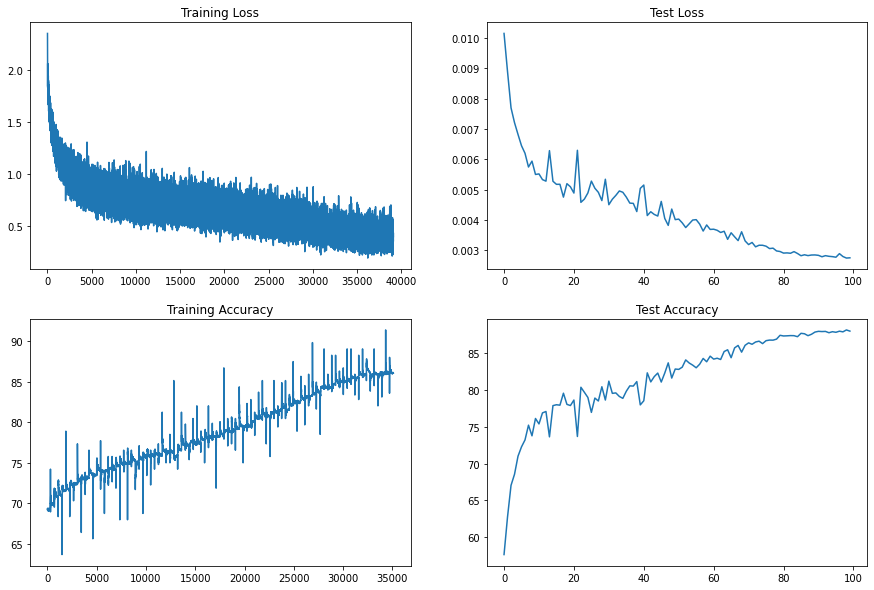

In [8]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Accuracy per class

In [9]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of plane : 76 %
Accuracy of   car : 92 %
Accuracy of  bird : 74 %
Accuracy of   cat : 60 %
Accuracy of  deer : 90 %
Accuracy of   dog : 85 %
Accuracy of  frog : 96 %
Accuracy of horse : 92 %
Accuracy of  ship : 93 %
Accuracy of truck : 100 %
